Face Recognition with dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("owlxiaoliu/four-binary-classification-datasets-of-faces")

print("Path to dataset files:", path)

100%|██████████| 4.39G/4.39G [00:52<00:00, 90.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/owlxiaoliu/four-binary-classification-datasets-of-faces/versions/1


In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# Set dataset path
dataset_path = '/root/.cache/kagglehub/datasets/owlxiaoliu/four-binary-classification-datasets-of-faces/versions/1/RealHumanGenderTest/RealHumanGenderTest'
class_names = ['Female', 'Male']

data = []
labels = []

# Load and preprocess images
female_images = []
male_images = []

for label, class_name in enumerate(class_names):
    folder_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipped: {img_path}")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (128, 128))

        if class_name == 'Female':
            female_images.append((resized, label))
        else:
            male_images.append((resized, label))

# Balance the dataset by reducing the number of female images
num_male_images = len(male_images)
if len(female_images) > num_male_images:
    female_images = random.sample(female_images, num_male_images)

data.extend([img for img, label in female_images])
labels.extend([label for img, label in female_images])
data.extend([img for img, label in male_images])
labels.extend([label for img, label in male_images])


# Convert and normalize
data = np.array(data, dtype='float32') / 255.0
data = np.expand_dims(data, axis=-1)  # (N, 128, 128, 1)
labels = np.array(labels)
labels = to_categorical(labels, num_classes=2)

# Split
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [9]:
male_count = np.sum(labels[:, 1])
print(f"Number of Male labels: {int(male_count)}")
female_count = np.sum(labels[:, 0])
print(f"Number of Male labels: {int(female_count)}")

Number of Male labels: 8459
Number of Male labels: 8459


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")  # 2 classes: Female, Male
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,050 (32.36 MB)

 Trainable params: 8,482,050 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(trainY, axis=1)),
    y=np.argmax(trainY, axis=1)
)
class_weights = dict(enumerate(class_weights))

# Pass to model.fit()
history = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=5,
    batch_size=32,
    class_weight=class_weights
)


Epoch 1/5
423/423 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7449 - loss: 0.4890 - val_accuracy: 0.9382 - val_loss: 0.1659
Epoch 2/5
423/423 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9382 - loss: 0.1609 - val_accuracy: 0.9501 - val_loss: 0.1315
Epoch 3/5
423/423 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9558 - loss: 0.1168 - val_accuracy: 0.9545 - val_loss: 0.1321
Epoch 4/5
423/423 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9664 - loss: 0.0874 - val_accuracy: 0.9631 - val_loss: 0.1107
Epoch 5/5
423/423 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9784 - loss: 0.0593 - val_accuracy: 0.9607 - val_loss: 0.1178


In [12]:
model.save('gender_classifier_model.h5')

In [13]:
loss, acc = model.evaluate(testX, testY)
print(f"Test Accuracy: {acc * 100:.2f}%")

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9620 - loss: 0.1120
Test Accuracy: 96.07%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: Female


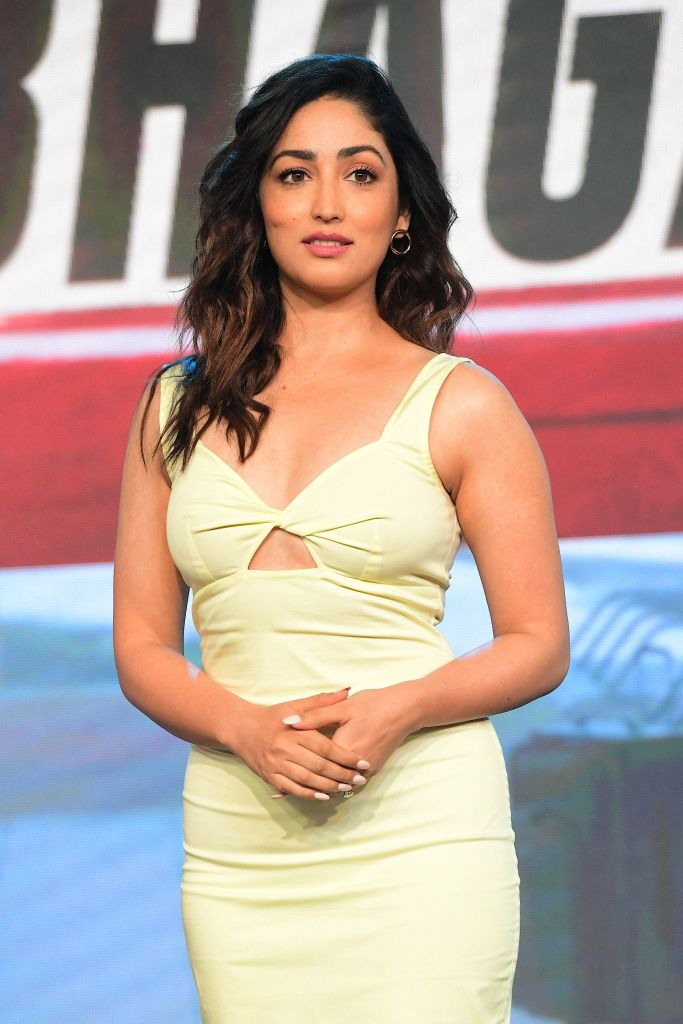

In [17]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Direct file path
filename = "/content/MV5BZGI4NDMxMjctOWU1YS00YjIxLWExMGEtNjM4NGJmNGJmNTYzXkEyXkFqcGc@._V1_.jpg"

# Load and preprocess the image
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (128, 128))
input_img = np.expand_dims(resized, axis=(0, -1)) / 255.0

# Predict
pred = model.predict(input_img)
class_names = ['Female', 'Male']
result = class_names[np.argmax(pred)]

# Display
print(f"Prediction: {result}")
cv2_imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Male


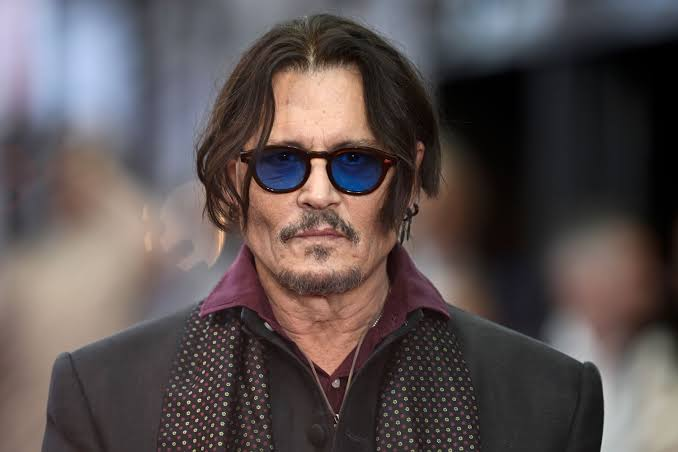

In [18]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Direct file path
filename = "/content/images.jpeg"

# Load and preprocess the image
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (128, 128))
input_img = np.expand_dims(resized, axis=(0, -1)) / 255.0

# Predict
pred = model.predict(input_img)
class_names = ['Female', 'Male']
result = class_names[np.argmax(pred)]

# Display
print(f"Prediction: {result}")
cv2_imshow(img)